Run Aspect

In this Notebook, we demonstrate how to run aspect model, modify the parameters and plot with vtk package

We will use the main branch of aspect installation and run simple cookbook models

Note:

Keep update to my onenote "run aspect notebook"

In [1]:
import os, sys
from pathlib import Path
import numpy as np
import re
from matplotlib import pyplot as plt

# import hamageolib packages and related modules, functions
root_path = os.path.join(Path().resolve().parent.parent.parent)
package_path = os.path.join(root_path, "hamageolib")

if str(package_path) not in sys.path:
    sys.path.insert(0, str(package_path))

import utils.plot_helper as plot_helper # plotting utilities

# Set up

Here we read the original prm file, modify it's output path and save to new location

In [2]:
aspect_dir = "/home/lochy/Softwares/aspect" # change this to your installed location of aspect
aspect_executable = os.path.join(aspect_dir, "build_master_TwoD/aspect")
prm_template_path = os.path.join(aspect_dir, "cookbooks", "convection-box/convection-box.prm")

assert(os.path.isfile(aspect_executable))
assert(os.path.isfile(prm_template_path))

# assign another directory to run the case
case_root_dir = os.path.join(root_path, "dtemp") 
case_dir = os.path.join(case_root_dir, "convection-box")  # New directory to run the case

# Create New case and run

## Create new case

By setting option to false, we skip running the case and proceed to post-processing with existing data

    create_and_run_case = False

In [3]:
create_and_run_case = False

if create_and_run_case:

    from shutil import rmtree
    from utils.dealii_param_parser import parse_parameters_to_dict, save_parameters_from_dict
    from utils.world_builder_file_parser import find_feature_by_name, update_or_add_feature

    # remove old directories
    if os.path.isdir(case_dir):
        rmtree(case_dir)
    os.mkdir(case_dir)

    # Modify the template
    # Also read important parameters like the size of the model

    with open(prm_template_path, 'r') as file:
        params_dict = parse_parameters_to_dict(file)

    params_dict["Output directory"] = os.path.join(case_dir, "output")

    # Write to a prm file in the new case directory
    prm_path = os.path.join(case_dir, "case.prm")

    with open(prm_path, 'w') as output_file:
        save_parameters_from_dict(output_file, params_dict)

    assert(os.path.isfile(prm_path))

    print("Created case in %s" % (case_dir))

## Run new case

Use "subprocess.run" to run the case.

Capture the standard output and error streams

Check
  * if the expected line indicating wallclock time appears in the output.
  * There is no stderr output.

In [4]:
if create_and_run_case:

    import subprocess

    # Run the ASPECT executable with the parameter file
    # The function ensures that both the expected outputs are generated and no errors are produced
    # 'capture_output=True' collects both stdout and stderr for further checks
    completed_process = subprocess.run([aspect_executable, prm_path], capture_output=True, text=True)

    # Capture the standard output and error streams
    stdout = completed_process.stdout
    stderr = completed_process.stderr

    # Uncomment the following lines for debugging purposes to inspect the output
    # print(stdout)  # Debugging: Prints the standard output
    # print(stderr)  # Debugging: Prints the standard error

    # Check if the expected line indicating wallclock time appears in the output
    # The expected line format is something like:
    # -- Total wallclock time elapsed including restarts: 1s
    assert(re.match(".*Total wallclock", stdout.split('\n')[-6]))

    # Ensure that the error stream is empty, indicating no issues during the run
    assert(stderr.strip() == "")

# Post-processing

In this block:
  * Use vtk package to read from vtu files (need to set the snapshot, here we use 49)
  * Convert data (coordinates and fields) to numpy array
  * initiate interpolators (Here we give the example of T, P and resolution)

In [5]:
do_stream_line_postprocess = True

if do_stream_line_postprocess:

    import vtk
    from vtk.util.numpy_support import vtk_to_numpy
    from utils.vtk_utilities import calculate_resolution
    import time
    from scipy.interpolate import LinearNDInterpolator

    pvtu_file = os.path.join(case_dir, "output", "solution", "solution-00049.pvtu")
    assert(os.path.isfile(pvtu_file))

    # Read the pvtu file
    start = time.time()

    reader = vtk.vtkXMLPUnstructuredGridReader()
    reader.SetFileName(pvtu_file)
    reader.Update()

    end = time.time()
    print("Initiating reader takes %.2e s" % (end - start))
    start = end

    # Get the output data from the reader
    grid = reader.GetOutput()  # Access the unstructured grid
    data_set = reader.GetOutputAsDataSet()  # Access the dataset representation
    points = grid.GetPoints()  # Extract the points (coordinates)
    cells = grid.GetCells()  # Extract the cell connectivity information
    point_data = data_set.GetPointData()  # Access point-wise data

    n_points = grid.GetNumberOfPoints() # Number of points and cells
    n_cells = grid.GetNumberOfCells()

    end = time.time()
    print("Reading files takes %.2e s" % (end - start))
    print(f"\tNumber of points: {n_points}")
    print(f"\tNumber of cells: {n_cells}")
    print("\tAvailable point data fields:")
    for i in range(point_data.GetNumberOfArrays()):
        # Field names in point data
        name = point_data.GetArrayName(i)
        print(f"\t  - {name}")
    start = end

    # Convert data to numpy array
    # Get coordinates (points)
    # Get field "T"

    vtk_points = grid.GetPoints().GetData()
    points_np = vtk_to_numpy(vtk_points)  # Shape: (n_points, 3)
    points_2d = points_np[:, :2]  # Use only the first two columns for 2D coordinates

    # Initialize dictionary for interpolators
    interpolators = {}

    # Loop over all arrays in point data
    num_arrays = point_data.GetNumberOfArrays()
    for i in range(num_arrays):
        array_name = point_data.GetArrayName(i)
        vtk_array = point_data.GetArray(i)
        
        if vtk_array is None:
            print(f"Warning: Array {array_name} is None, skipping.")
            continue
        
        # Convert VTK array to NumPy
        np_array = vtk_to_numpy(vtk_array)
        
        # Create interpolator and add to dict
        interpolators[array_name] = LinearNDInterpolator(points_2d, np_array, fill_value=np.nan)

    # Calculate resolution for each cell or point in the grid
    resolution_np = calculate_resolution(grid)  # Custom function (not defined here)

    end = time.time()
    print("Calculating resolution takes %.2e s" % (end - start))
    start = end

    # Create interpolators for temperature, pressure, and resolution
    interpolators["resolution"] = LinearNDInterpolator(points_2d, resolution_np)  # Interpolator for resolution

    end = time.time()
    print("Construct linear ND interpolator takes %.2e s" % (end - start))
    start = end

Initiating reader takes 2.82e-03 s
Reading files takes 7.22e-05 s
	Number of points: 2304
	Number of cells: 1024
	Available point data fields:
	  - velocity
	  - p
	  - T
Calculating resolution takes 5.15e-02 s
Construct linear ND interpolator takes 4.92e-03 s


Next use the interpolator we have to generate a grid to plot

- Note the interval is defined by meter
- xs and ys are generate with slightly different interval, therefore we always get different number of nodes along x and y, making it easier to debug (It's generally easier when a 2-d array have different sizes along the 2 dimensions, that you can easier tell which is which.)

In [6]:
if do_stream_line_postprocess:

    start = time.time()

    # Define the interval for the grid (in meters)
    interval = 0.01

    # Determine the bounding box of the 2D points
    x_min, y_min = np.min(points_2d, axis=0)
    x_max, y_max = np.max(points_2d, axis=0)

    # Define a regular grid within the bounding box
    # allow a little different in interval in x
    # and y axis, thereform making the two dimensions
    # unequal to make fewer mistakes ...
    xs = np.arange(x_min, x_max, interval*0.99)
    ys = np.arange(y_min, y_max, interval*1.01)
    x_grid, y_grid = np.meshgrid(xs, ys, indexing="ij")  # Create a grid of (x, y) points

    # Flatten the grid for interpolation
    grid_points_2d = np.vstack([x_grid.ravel(), y_grid.ravel()]).T

    # Interpolate temperature (T) values onto the regular grid
    T_grid = interpolators["T"](grid_points_2d)  # Use the NearestNDInterpolator
    T_grid = T_grid.reshape(x_grid.shape)  # Reshape back to the grid

    # Interpolate temperature (P) values onto the regular grid
    P_grid = interpolators["p"](grid_points_2d)  # Use the NearestNDInterpolator
    P_grid = P_grid.reshape(x_grid.shape)  # Reshape back to the grid

    # Interpolate resolutions onto the regular grid
    resolutions_grid = interpolators["resolution"](grid_points_2d)
    resolutions_grid = resolutions_grid.reshape(x_grid.shape)

    # Interpolate velocities onto the regular grid
    velocity_grid = interpolators["velocity"](grid_points_2d)
    velocity_grid = velocity_grid.reshape([x_grid.shape[0], x_grid.shape[1],3])
    vx_grid = velocity_grid[:, :, 0]
    vy_grid = velocity_grid[:, :, 1]

    end = time.time()
    print("Interpolating to regular grid takes %.2e s" % (end - start))
    print("\tgrid shape: (x axis, y axis): ", x_grid.shape)
    start = end

Interpolating to regular grid takes 1.94e-02 s
	grid shape: (x axis, y axis):  (102, 100)


Now plot

Here we use the grid we created.
	
SCM color schemes are used for the color plots.

- Note we set the plot options in the block at the start.

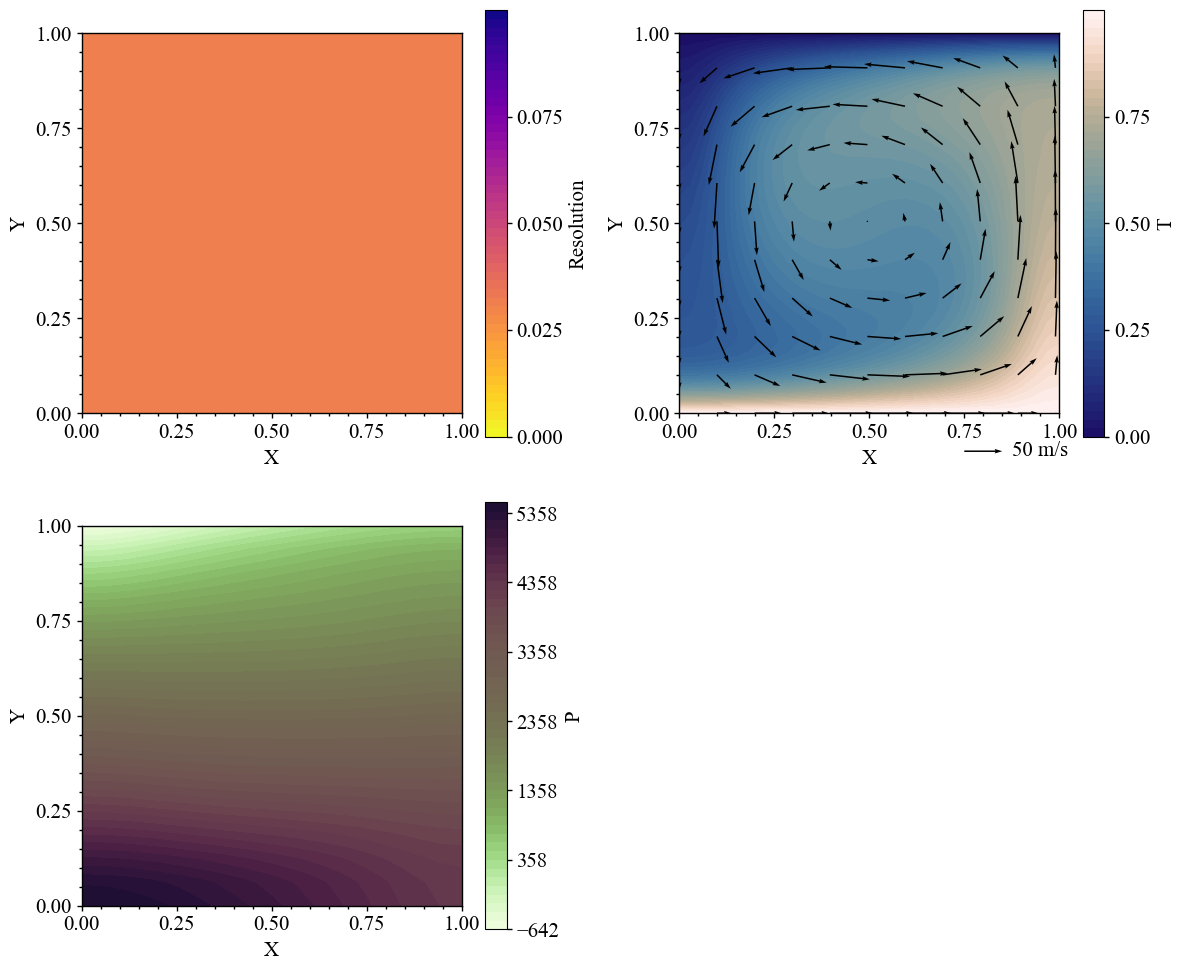

In [ ]:
if do_stream_line_postprocess:

    from matplotlib import rcdefaults
    from matplotlib.ticker import MultipleLocator
    from matplotlib import gridspec
    from cmcrameri import cm as ccm

    # Retrieve the default color cycle
    default_colors = [color['color'] for color in plt.rcParams['axes.prop_cycle']]

    # Example usage
    # Rule of thumbs:
    # 1. Set the limit to something like 5.0, 10.0 or 50.0, 100.0 
    # 2. Set five major ticks for each axis
    scaling_factor = 1.0  # scale factor of plot
    font_scaling_multiplier = 1.5 # extra scaling multiplier for font
    legend_font_scaling_multiplier = 0.5
    line_width_scaling_multiplier = 2.0 # extra scaling multiplier for lines
    x_lim = (0.0, 1.0)
    x_tick_interval = 0.25   # tick interval along x
    y_lim = (0.0, 1.0)
    y_tick_interval = 0.25  # tick interval along y

    resolution_lim = (0.0, 0.1) # resolution
    resolution_level = 50  # number of levels in contourf plot
    resolution_tick_interval = 0.025  # tick interval along v

    T_lim = (0.0, 1.0) # T
    T_level = 50  # number of levels in contourf plot
    T_tick_interval = 0.25  # tick interval along v

    P_lim = (np.min(P_grid), np.max(P_grid)) # P
    P_level = 50  # number of levels in contourf plot
    P_tick_interval = 1e3  # tick interval along v

    n_minor_ticks = 4  # number of minor ticks between two major ones

    # scale the matplotlib params
    plot_helper.scale_matplotlib_params(scaling_factor, font_scaling_multiplier=font_scaling_multiplier,\
                            legend_font_scaling_multiplier=legend_font_scaling_multiplier,
                            line_width_scaling_multiplier=line_width_scaling_multiplier)

    # Update font settings for compatibility with publishing tools like Illustrator.
    plt.rcParams.update({
        'font.family': 'Times New Roman',
        'pdf.fonttype': 42,
        'ps.fonttype': 42
    })

    # Create a figure with a 2x2 grid layout
    fig = plt.figure(figsize=(12, 10), tight_layout=True)
    gs = gridspec.GridSpec(2, 2)

    # Plot the mesh resolution
    ax = fig.add_subplot(gs[0, 0])

    levels = np.linspace(resolution_lim[0], resolution_lim[1], resolution_level)
    ticks=np.arange(resolution_lim[0], resolution_lim[1], resolution_tick_interval)

    color_map = ax.contourf(x_grid, y_grid, resolutions_grid,  vmin=resolution_lim[0], vmax=resolution_lim[1], levels=levels, cmap="plasma_r")  # Resolution colormap
    cbar = fig.colorbar(color_map, ax=ax, label="Resolution")  # Add colorbar
    cbar.set_ticks(ticks)

    ax.set_aspect("equal", adjustable="box")  # Equal aspect ratio

    ax.set_xlim(x_lim)
    ax.set_ylim(y_lim)

    ax.xaxis.set_major_locator(MultipleLocator(x_tick_interval))
    ax.xaxis.set_minor_locator(MultipleLocator(x_tick_interval/(n_minor_ticks+1)))
    ax.yaxis.set_major_locator(MultipleLocator(y_tick_interval))
    ax.yaxis.set_minor_locator(MultipleLocator(y_tick_interval/(n_minor_ticks+1)))

    ax.set_xlabel("X")
    ax.set_ylabel("Y")

    for spine in ax.spines.values():
        # Adjust spine thickness for this plot
        spine.set_linewidth(0.5 * scaling_factor * line_width_scaling_multiplier)


    # Plot T
    # Note on the quiver:
    #   the length actually between shorter with longere "scale"
    #   so maintain "scale = U*10.0", where U is the key in "quiverkey"
    ax = fig.add_subplot(gs[0, 1])

    levels = np.linspace(T_lim[0], T_lim[1], T_level)
    ticks=np.arange(T_lim[0], T_lim[1], T_tick_interval)

    color_map = ax.contourf(x_grid, y_grid, T_grid,  vmin=T_lim[0], vmax=T_lim[1], levels=levels, cmap=ccm.lapaz)  # Resolution colormap
    cbar = fig.colorbar(color_map, ax=ax, label="T")  # Add colorbar
    cbar.set_ticks(ticks)

    step = 10  # plot every 5th vector
    qv = ax.quiver(x_grid[::step, ::step], y_grid[::step, ::step],\
                vx_grid[::step, ::step], vy_grid[::step, ::step],\
                    scale=500, width=0.004, color='black')
    ax.quiverkey(qv, X=0.85, Y=-0.1, U=50.0, label='50 m/s', labelpos='E')

    ax.set_aspect("equal", adjustable="box")  # Equal aspect ratio

    ax.set_xlim(x_lim)
    ax.set_ylim(y_lim)

    ax.xaxis.set_major_locator(MultipleLocator(x_tick_interval))
    ax.xaxis.set_minor_locator(MultipleLocator(x_tick_interval/(n_minor_ticks+1)))
    ax.yaxis.set_major_locator(MultipleLocator(y_tick_interval))
    ax.yaxis.set_minor_locator(MultipleLocator(y_tick_interval/(n_minor_ticks+1)))

    ax.set_xlabel("X")
    ax.set_ylabel("Y")

    for spine in ax.spines.values():
        # Adjust spine thickness for this plot
        spine.set_linewidth(0.5 * scaling_factor * line_width_scaling_multiplier)


    # Plot P
    ax = fig.add_subplot(gs[1, 0])

    levels = np.linspace(P_lim[0], P_lim[1], P_level)
    ticks=np.arange(P_lim[0], P_lim[1], P_tick_interval)

    color_map = ax.contourf(x_grid, y_grid, P_grid,  vmin=P_lim[0], vmax=P_lim[1], levels=levels, cmap=ccm.tokyo_r)  # Resolution colormap
    cbar = fig.colorbar(color_map, ax=ax, label="P")  # Add colorbar
    cbar.set_ticks(ticks)

    ax.set_aspect("equal", adjustable="box")  # Equal aspect ratio

    ax.set_xlim(x_lim)
    ax.set_ylim(y_lim)

    ax.xaxis.set_major_locator(MultipleLocator(x_tick_interval))
    ax.xaxis.set_minor_locator(MultipleLocator(x_tick_interval/(n_minor_ticks+1)))
    ax.yaxis.set_major_locator(MultipleLocator(y_tick_interval))
    ax.yaxis.set_minor_locator(MultipleLocator(y_tick_interval/(n_minor_ticks+1)))

    ax.set_xlabel("X")
    ax.set_ylabel("Y")

    for spine in ax.spines.values():
        # Adjust spine thickness for this plot
        spine.set_linewidth(0.5 * scaling_factor * line_width_scaling_multiplier)


    # Reset rcParams to defaults
    rcdefaults()